In [1]:
import sigopt
import os
import numpy as np
import logging
import deeptime.markov.msm as dm
import tqdm.auto as tqdm
import mr_toolkit.trajectory_analysis.traj_analysis as ta
from mr_toolkit.reweighting.analysis import get_set_kls
import synd.core
from mr_toolkit.reweighting import analysis as rwa
import matplotlib.pyplot as plt
from scipy.stats import entropy

[17:26:03] INFO     Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing    ]8;id=840530;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/numexpr/utils.py\utils.py]8;;\:]8;id=461960;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/numexpr/utils.py#148\148]8;;\
                    safe limit of 8.                                                                               

           INFO     NumExpr defaulting to 8 threads.                                                   ]8;id=33311;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/numexpr/utils.py\utils.py]8;;\:]8;id=617951;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/numexpr/utils.py#160\160]8;;\

           WARNING  msm_we not found, fpt_distribution calculations will be unavailable              ]8;id=495500;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/reweighting/analysis.py\analysis.py]8;;\:]8;id=162440;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/reweighting/analysis.py#18\18]8;;\

# Hyperparameter optimization with SigOpt

To build a reweighted MSM using a given set of trajectories, there are a number of sensitive hyperparameters.
These include:
- MSM lagtime
- Fragment length
- Last-fraction of trajectories to use

Besides lagtime, it's not necessarily clear how to choose these.

This notebook demonstrates a heuristic optimization approach that works by splitting up the input dataset into subsets, and identifying the hyperparameters that provide maximal similarity across subsets.
This assumes that self-consistency across subsets means we're getting reasonably consistent estimates.

This criteria is just a loose guide -- by no means is it rigorously considered an optimal criterion!

In [2]:
n_trajectories = 400
trajectory_length = 20

n_subsets = 4

# From the underlying model
n_states = 100

First, verify an API key is stored in the environment. To get an API key for sigopt, [register for an account](https://app.sigopt.com/signup) and then visit [the token page](https://app.sigopt.com/tokens/info).

In [3]:
if os.environ.get('SIGOPT_API_TOKEN', None) is None:
    raise Exception('Set $SIGOPT_API_TOKEN in your environment to use this notebook.')

Then create the sigopt project, or use the existing one.

**NB:** One nice detail about sigopt is that successive optimizations in the same project will learn from previous runs, even if they're in a new experiment.

In [4]:
if 'SIGOPT_PROJECT' not in os.environ.keys():

    project_name = 'sample_optimization'
    
    print(f'$SIGOPT_PROJECT not set in environment -- creating a new project named {project_name}.')

    try:
        sigopt.create_project(project_name)
    except sigopt.factory.ConflictingProjectException as e:
        print("Sigopt project already exists, using that.")

    os.environ['SIGOPT_PROJECT'] = project_name

$SIGOPT_PROJECT not set in environment -- creating a new project named sample_optimization.
Sigopt project already exists, using that.


## Generate sample data

In [5]:
state_definitions = np.load('sample_data/coarser-state_definitions.npz')

source_states = state_definitions['source']
target_states = state_definitions['target']

In [6]:
synd_model = synd.core.load_model('sample_data/coarser-model.synd')

# Set the SynD model seed so we get the same random trajectories
synd_model.rng = np.random.default_rng(seed=50)

In [7]:
ref_equil = np.load('sample_data/coarser-reference_distributions.npz')['equil']

In [8]:
initial_points = synd_model.rng.choice(np.arange(n_states), n_trajectories)

trajectories = synd_model.generate_trajectory(
    initial_states = initial_points,
    n_steps = trajectory_length
)

### Split data into subsets

First, let's split our data up into equal-size subsets.

In [9]:
datasets = np.array([trajectories[i::n_subsets] for i in range(n_subsets)])

## Test parameters on subsets to identify optimal

Now, we'll run a Sigopt experiment to identify the "optimal" set of parameters.

In [10]:
metaparameters = dict(
    trajectory_length=trajectory_length,
    n_trajectories_per_set=n_trajectories // n_subsets,
    n_trajectory_sets=n_subsets,
    
    # These below probably won't change much
    min_weight=1e-12,  # This just helps with numerical stability during the reweighting iteration
    n_reweight_iters=100,
)

### Define parameter space

In [11]:
experiment = sigopt.create_experiment(
        name=f"Sample optimization",
    
        budget=50,
    
        parameters=[
            dict(name='N', 
                 type='int', 
                 bounds={'min': 2, 'max':trajectory_length-1 }),
            
            dict(name='last_frac', 
                 type='double', 
                 grid=[0.25, 0.5, 0.75, 1.0]),
            
            dict(name='lag', 
                 type='int', 
                 bounds={'min': 1, 'max': trajectory_length-1 }),
        ],
    
        metrics=[
            {
                "name": "lag_vs_N",
                "strategy": "constraint",
                "objective": "minimize",
                "threshold": 1.0,
            },
            {
                "name": "avg_set_iterative_kl",
                "strategy": "optimize",
                "objective": "minimize",
            },
        ],
    
        metadata=dict(
            trajectory_length=trajectory_length,
            n_trajectories_per_set=n_trajectories // n_subsets,
            n_trajectory_sets=n_subsets,

            # These below probably won't change much
            min_weight=1e-12,  # This just helps with numerical stability during the reweighting iteration
            n_reweight_iters=100,
        ),
    )

[17:26:04] INFO     AI Experiment created, view it on the SigOpt dashboard at                         ]8;id=167944;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/factory.py\factory.py]8;;\:]8;id=576757;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/factory.py#54\54]8;;\
                    https://app.sigopt.com/aiexperiment/570847                                                     

## Perform optimization

We'll do a number of runs now (determined by the budget above) to explore the hyperparameter space.

We'll let Sigopt's ML engine guide the parameter choices, and only concern ourselves with the final result.

In [12]:
for run in tqdm.tqdm(experiment.loop(), desc='SigOpt runs', total=int(experiment.progress.remaining_budget)):
    with run:
        
        # Lag time must be shorter than N, so this must be below 1
        lag_vs_N = run.params["lag"] / run.params["N"]
        run.log_metric("lag_vs_N", lag_vs_N)
        if lag_vs_N >= 1.0:
            print("Invalid lag / N combination, skipping to next run")
            continue
            
        # Estimate reweighted equilibrium distribution for each set
        reweighted_equil_estimates = np.full((n_subsets, n_states), fill_value=np.nan)
        
        for i, trajectory_set in enumerate(datasets):
            
            (states, stationaries, last_iter, reweighted_matrices,) = rwa.compute_reweighted_stationary(
                trajectory_set,
                N=run.params["N"],
                lag=run.params["lag"],
                last_frac=run.params['last_frac'],
                n_clusters=n_states,
                n_reweighting_iters=metaparameters['n_reweight_iters'],
                min_weight=metaparameters['min_weight'],
            )
            
            print(last_iter)
            
            reweighted_equil_estimates[i] = stationaries[last_iter]
        
        mean_kl = get_set_kls(reweighted_equil_estimates)
        
        if np.isnan(mean_kl):
            mean_kl = 10
    
        # Log set-set KL divergence
        run.log_metric('avg_set_iterative_kl', mean_kl)

SigOpt runs:   0%|          | 0/50 [00:00<?, ?it/s]

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=871938;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=558761;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604117                                                              

Invalid lag / N combination, skipping to next run


[17:26:05] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=608814;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=213777;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604117                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=974367;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=333632;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604118                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=719751;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=961047;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604118                                                              

[17:26:06] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=719073;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=770349;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604119                                                              

Building count matrices:   0%|          | 0/1800 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 26
26


Building count matrices:   0%|          | 0/1800 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 22
22


Building count matrices:   0%|          | 0/1800 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 24
24


Building count matrices:   0%|          | 0/1800 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 33
33


[17:26:07] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=638057;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=608713;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604119                                                              

[17:26:08] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=278799;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=181351;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604120                                                              

Building count matrices:   0%|          | 0/1100 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

/home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py:510: RuntimeWarning: divide by zero encountered in log
  np.log(stationary_distributions[-1]) - np.log(stationary_distributions[-2])
/home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py:510: RuntimeWarning: invalid value encountered in subtract
  np.log(stationary_distributions[-1]) - np.log(stationary_distributions[-2])


reweighted iteration is converged at iter 33
33


Building count matrices:   0%|          | 0/1100 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 32
32


Building count matrices:   0%|          | 0/1100 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 32
32


Building count matrices:   0%|          | 0/1100 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 29
29


[17:26:09] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=505331;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=342432;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604120                                                              

[17:26:10] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=37288;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=212002;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604121                                                              

Building count matrices:   0%|          | 0/1700 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 40
40


Building count matrices:   0%|          | 0/1700 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 34
34


Building count matrices:   0%|          | 0/1700 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 26
26


Building count matrices:   0%|          | 0/1700 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 29
29


[17:26:11] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=614503;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=698782;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604121                                                              

[17:26:12] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=885555;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=742197;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604122                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=438705;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=436322;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604122                                                              

[17:26:13] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=86716;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=435470;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604123                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=716815;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=152387;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604123                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=649121;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=734205;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604124                                                              

Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 65
65


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 39
39


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 23
23


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 33
33


[17:26:15] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=633455;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=648440;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604124                                                              

[17:26:16] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=76866;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=322267;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604125                                                              

Building count matrices:   0%|          | 0/1400 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 23
23


Building count matrices:   0%|          | 0/1400 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 24
24


Building count matrices:   0%|          | 0/1400 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 23
23


Building count matrices:   0%|          | 0/1400 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 26
26


[17:26:17] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=29596;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=887730;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604125                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=638424;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=720173;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604126                                                              

Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

[17:26:18] WARNING  Stationary solution 1 is all in one bin in iter 0 -- picking next-biggest  ]8;id=861674;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=836010;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 2 is all in one bin in iter 0 -- picking next-biggest  ]8;id=971682;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=580443;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 3 is all in one bin in iter 0 -- picking next-biggest  ]8;id=508918;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=450957;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 4 is all in one bin in iter 0 -- picking next-biggest  ]8;id=213133;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=741689;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 5 is all in one bin in iter 0 -- picking next-biggest  ]8;id=326275;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=541446;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 6 is all in one bin in iter 0 -- picking next-biggest  ]8;id=208462;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=390425;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 7 is all in one bin in iter 0 -- picking next-biggest  ]8;id=531224;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=30147;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 8 is all in one bin in iter 0 -- picking next-biggest  ]8;id=448100;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=215795;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 9 is all in one bin in iter 0 -- picking next-biggest  ]8;id=422166;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=157223;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 10 is all in one bin in iter 0 -- picking next-biggest ]8;id=129830;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=929782;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 11 is all in one bin in iter 0 -- picking next-biggest ]8;id=638393;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=812206;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 12 is all in one bin in iter 0 -- picking next-biggest ]8;id=225668;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=301943;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 13 is all in one bin in iter 0 -- picking next-biggest ]8;id=563842;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=96039;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 14 is all in one bin in iter 0 -- picking next-biggest ]8;id=555707;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=5397;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 15 is all in one bin in iter 0 -- picking next-biggest ]8;id=128712;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=229945;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 16 is all in one bin in iter 0 -- picking next-biggest ]8;id=447739;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=215390;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 17 is all in one bin in iter 0 -- picking next-biggest ]8;id=490149;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=337697;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 18 is all in one bin in iter 0 -- picking next-biggest ]8;id=858286;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=7254;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 19 is all in one bin in iter 0 -- picking next-biggest ]8;id=632237;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=308377;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 20 is all in one bin in iter 0 -- picking next-biggest ]8;id=663009;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=632658;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 21 is all in one bin in iter 0 -- picking next-biggest ]8;id=340922;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=721754;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 22 is all in one bin in iter 0 -- picking next-biggest ]8;id=155423;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=607866;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 23 is all in one bin in iter 0 -- picking next-biggest ]8;id=272681;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=80948;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 24 is all in one bin in iter 0 -- picking next-biggest ]8;id=920981;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=116818;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 25 is all in one bin in iter 0 -- picking next-biggest ]8;id=543029;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=613080;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 26 is all in one bin in iter 0 -- picking next-biggest ]8;id=824403;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=65271;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 27 is all in one bin in iter 0 -- picking next-biggest ]8;id=900475;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=571802;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 28 is all in one bin in iter 0 -- picking next-biggest ]8;id=730840;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=696548;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 29 is all in one bin in iter 0 -- picking next-biggest ]8;id=950929;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=360903;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 30 is all in one bin in iter 0 -- picking next-biggest ]8;id=465851;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=352035;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 31 is all in one bin in iter 0 -- picking next-biggest ]8;id=621190;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=19276;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 32 is all in one bin in iter 0 -- picking next-biggest ]8;id=680399;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=860710;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 33 is all in one bin in iter 0 -- picking next-biggest ]8;id=677299;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=799003;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 34 is all in one bin in iter 0 -- picking next-biggest ]8;id=909504;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=306840;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 35 is all in one bin in iter 0 -- picking next-biggest ]8;id=403489;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=236549;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 36 is all in one bin in iter 0 -- picking next-biggest ]8;id=941545;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=793940;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 37 is all in one bin in iter 0 -- picking next-biggest ]8;id=530646;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=148956;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 38 is all in one bin in iter 0 -- picking next-biggest ]8;id=816728;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=485729;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 39 is all in one bin in iter 0 -- picking next-biggest ]8;id=912665;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=79970;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 40 is all in one bin in iter 0 -- picking next-biggest ]8;id=810389;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=157646;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 41 is all in one bin in iter 0 -- picking next-biggest ]8;id=28779;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=823950;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 42 is all in one bin in iter 0 -- picking next-biggest ]8;id=502816;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=33010;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 43 is all in one bin in iter 0 -- picking next-biggest ]8;id=84184;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=444156;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 44 is all in one bin in iter 0 -- picking next-biggest ]8;id=188556;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=61300;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 45 is all in one bin in iter 0 -- picking next-biggest ]8;id=700842;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=448499;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 46 is all in one bin in iter 0 -- picking next-biggest ]8;id=645220;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=314047;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 47 is all in one bin in iter 0 -- picking next-biggest ]8;id=715412;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=211578;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 48 is all in one bin in iter 0 -- picking next-biggest ]8;id=326781;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=513228;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 49 is all in one bin in iter 0 -- picking next-biggest ]8;id=980454;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=97522;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 50 is all in one bin in iter 0 -- picking next-biggest ]8;id=86542;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=79467;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 51 is all in one bin in iter 0 -- picking next-biggest ]8;id=765997;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=593405;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 52 is all in one bin in iter 0 -- picking next-biggest ]8;id=208594;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=159216;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 53 is all in one bin in iter 0 -- picking next-biggest ]8;id=454169;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=880357;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 54 is all in one bin in iter 0 -- picking next-biggest ]8;id=720677;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=416911;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 55 is all in one bin in iter 0 -- picking next-biggest ]8;id=320535;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=101917;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 56 is all in one bin in iter 0 -- picking next-biggest ]8;id=217327;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=531614;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 57 is all in one bin in iter 0 -- picking next-biggest ]8;id=55213;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=412532;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 58 is all in one bin in iter 0 -- picking next-biggest ]8;id=552304;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=198294;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 59 is all in one bin in iter 0 -- picking next-biggest ]8;id=728260;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=963837;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 60 is all in one bin in iter 0 -- picking next-biggest ]8;id=2917;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=396976;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 61 is all in one bin in iter 0 -- picking next-biggest ]8;id=688879;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=985258;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 62 is all in one bin in iter 0 -- picking next-biggest ]8;id=652052;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=46874;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 63 is all in one bin in iter 0 -- picking next-biggest ]8;id=437012;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=678970;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 64 is all in one bin in iter 0 -- picking next-biggest ]8;id=903778;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=229946;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 65 is all in one bin in iter 0 -- picking next-biggest ]8;id=89275;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=203318;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 66 is all in one bin in iter 0 -- picking next-biggest ]8;id=145948;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=145616;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 67 is all in one bin in iter 0 -- picking next-biggest ]8;id=270738;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=796033;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 68 is all in one bin in iter 0 -- picking next-biggest ]8;id=465211;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=29651;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 69 is all in one bin in iter 0 -- picking next-biggest ]8;id=245437;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=823264;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 70 is all in one bin in iter 0 -- picking next-biggest ]8;id=73239;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=984952;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 71 is all in one bin in iter 0 -- picking next-biggest ]8;id=718677;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=267070;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 72 is all in one bin in iter 0 -- picking next-biggest ]8;id=45297;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=176972;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 73 is all in one bin in iter 0 -- picking next-biggest ]8;id=595998;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=551781;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 74 is all in one bin in iter 0 -- picking next-biggest ]8;id=899154;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=859425;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 75 is all in one bin in iter 0 -- picking next-biggest ]8;id=948976;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=769676;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 76 is all in one bin in iter 0 -- picking next-biggest ]8;id=50478;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=910901;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 77 is all in one bin in iter 0 -- picking next-biggest ]8;id=769674;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=785544;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 78 is all in one bin in iter 0 -- picking next-biggest ]8;id=942775;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=14664;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 79 is all in one bin in iter 0 -- picking next-biggest ]8;id=108391;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=900850;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 80 is all in one bin in iter 0 -- picking next-biggest ]8;id=700738;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=698041;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 81 is all in one bin in iter 0 -- picking next-biggest ]8;id=166018;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=289967;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 82 is all in one bin in iter 0 -- picking next-biggest ]8;id=778990;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=262941;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 83 is all in one bin in iter 0 -- picking next-biggest ]8;id=769910;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=548518;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 84 is all in one bin in iter 0 -- picking next-biggest ]8;id=199844;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=52240;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 85 is all in one bin in iter 0 -- picking next-biggest ]8;id=150341;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=403829;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 86 is all in one bin in iter 0 -- picking next-biggest ]8;id=912010;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=884846;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 87 is all in one bin in iter 0 -- picking next-biggest ]8;id=261845;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=819626;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 88 is all in one bin in iter 0 -- picking next-biggest ]8;id=530697;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=151847;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 89 is all in one bin in iter 0 -- picking next-biggest ]8;id=180571;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=6724;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 90 is all in one bin in iter 0 -- picking next-biggest ]8;id=570176;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=819902;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 91 is all in one bin in iter 0 -- picking next-biggest ]8;id=24848;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=137178;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 92 is all in one bin in iter 0 -- picking next-biggest ]8;id=708550;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=330002;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 93 is all in one bin in iter 0 -- picking next-biggest ]8;id=275734;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=618455;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 94 is all in one bin in iter 0 -- picking next-biggest ]8;id=466367;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=872263;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 95 is all in one bin in iter 0 -- picking next-biggest ]8;id=591133;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=307702;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 96 is all in one bin in iter 0 -- picking next-biggest ]8;id=633543;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=237389;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 97 is all in one bin in iter 0 -- picking next-biggest ]8;id=824304;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=358450;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 98 is all in one bin in iter 0 -- picking next-biggest ]8;id=426042;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=687471;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 99 is all in one bin in iter 0 -- picking next-biggest ]8;id=337036;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=771993;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           CRITICAL No good stationary solution exists! Stopping iteration at iter 0           ]8;id=998382;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=824575;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#470\470]8;;\

0


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

           WARNING  Stationary solution 1 is all in one bin in iter 0 -- picking next-biggest  ]8;id=816583;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=338019;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 2 is all in one bin in iter 0 -- picking next-biggest  ]8;id=896962;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=291160;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 3 is all in one bin in iter 0 -- picking next-biggest  ]8;id=246313;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=763684;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 4 is all in one bin in iter 0 -- picking next-biggest  ]8;id=463653;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=860824;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 5 is all in one bin in iter 0 -- picking next-biggest  ]8;id=345802;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=239190;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 6 is all in one bin in iter 0 -- picking next-biggest  ]8;id=760582;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=763817;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 7 is all in one bin in iter 0 -- picking next-biggest  ]8;id=72065;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=937731;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 8 is all in one bin in iter 0 -- picking next-biggest  ]8;id=633623;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=629420;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 9 is all in one bin in iter 0 -- picking next-biggest  ]8;id=508738;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=503892;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 10 is all in one bin in iter 0 -- picking next-biggest ]8;id=441473;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=847862;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 11 is all in one bin in iter 0 -- picking next-biggest ]8;id=530772;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=751031;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 12 is all in one bin in iter 0 -- picking next-biggest ]8;id=971583;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=551656;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 13 is all in one bin in iter 0 -- picking next-biggest ]8;id=203399;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=498578;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 14 is all in one bin in iter 0 -- picking next-biggest ]8;id=420529;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=994282;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 15 is all in one bin in iter 0 -- picking next-biggest ]8;id=545797;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=7204;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 16 is all in one bin in iter 0 -- picking next-biggest ]8;id=872698;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=260591;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 17 is all in one bin in iter 0 -- picking next-biggest ]8;id=75557;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=41996;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 18 is all in one bin in iter 0 -- picking next-biggest ]8;id=56294;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=22510;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 19 is all in one bin in iter 0 -- picking next-biggest ]8;id=658530;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=417770;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 20 is all in one bin in iter 0 -- picking next-biggest ]8;id=353495;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=288597;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 21 is all in one bin in iter 0 -- picking next-biggest ]8;id=646544;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=545650;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 22 is all in one bin in iter 0 -- picking next-biggest ]8;id=662918;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=245013;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 23 is all in one bin in iter 0 -- picking next-biggest ]8;id=750281;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=772267;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 24 is all in one bin in iter 0 -- picking next-biggest ]8;id=923854;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=803434;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 25 is all in one bin in iter 0 -- picking next-biggest ]8;id=216928;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=832821;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 26 is all in one bin in iter 0 -- picking next-biggest ]8;id=299907;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=328171;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 27 is all in one bin in iter 0 -- picking next-biggest ]8;id=20162;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=525277;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 28 is all in one bin in iter 0 -- picking next-biggest ]8;id=438041;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=740683;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 29 is all in one bin in iter 0 -- picking next-biggest ]8;id=823104;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=565010;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 30 is all in one bin in iter 0 -- picking next-biggest ]8;id=372305;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=214979;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 31 is all in one bin in iter 0 -- picking next-biggest ]8;id=362131;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=351485;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 32 is all in one bin in iter 0 -- picking next-biggest ]8;id=612509;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=23101;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 33 is all in one bin in iter 0 -- picking next-biggest ]8;id=978726;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=694883;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 34 is all in one bin in iter 0 -- picking next-biggest ]8;id=447949;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=805596;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 35 is all in one bin in iter 0 -- picking next-biggest ]8;id=876031;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=21711;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 36 is all in one bin in iter 0 -- picking next-biggest ]8;id=700386;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=195197;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 37 is all in one bin in iter 0 -- picking next-biggest ]8;id=687036;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=22582;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 38 is all in one bin in iter 0 -- picking next-biggest ]8;id=151395;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=237597;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 39 is all in one bin in iter 0 -- picking next-biggest ]8;id=531456;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=257160;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 40 is all in one bin in iter 0 -- picking next-biggest ]8;id=393159;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=179269;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 41 is all in one bin in iter 0 -- picking next-biggest ]8;id=572918;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=121570;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 42 is all in one bin in iter 0 -- picking next-biggest ]8;id=397960;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=752589;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 43 is all in one bin in iter 0 -- picking next-biggest ]8;id=659106;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=673104;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 44 is all in one bin in iter 0 -- picking next-biggest ]8;id=84858;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=772319;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 45 is all in one bin in iter 0 -- picking next-biggest ]8;id=712551;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=784827;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 46 is all in one bin in iter 0 -- picking next-biggest ]8;id=782716;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=942633;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 47 is all in one bin in iter 0 -- picking next-biggest ]8;id=10761;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=240888;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 48 is all in one bin in iter 0 -- picking next-biggest ]8;id=137187;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=682171;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 49 is all in one bin in iter 0 -- picking next-biggest ]8;id=262111;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=986138;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 50 is all in one bin in iter 0 -- picking next-biggest ]8;id=315396;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=496399;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 51 is all in one bin in iter 0 -- picking next-biggest ]8;id=272802;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=270451;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 52 is all in one bin in iter 0 -- picking next-biggest ]8;id=591086;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=198106;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 53 is all in one bin in iter 0 -- picking next-biggest ]8;id=90639;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=407517;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 54 is all in one bin in iter 0 -- picking next-biggest ]8;id=659723;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=914663;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 55 is all in one bin in iter 0 -- picking next-biggest ]8;id=547686;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=560761;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 56 is all in one bin in iter 0 -- picking next-biggest ]8;id=469044;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=97776;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 57 is all in one bin in iter 0 -- picking next-biggest ]8;id=33463;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=207482;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 58 is all in one bin in iter 0 -- picking next-biggest ]8;id=448664;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=92909;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 59 is all in one bin in iter 0 -- picking next-biggest ]8;id=219339;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=11749;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 60 is all in one bin in iter 0 -- picking next-biggest ]8;id=741736;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=323033;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 61 is all in one bin in iter 0 -- picking next-biggest ]8;id=71416;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=108993;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 62 is all in one bin in iter 0 -- picking next-biggest ]8;id=479108;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=521022;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 63 is all in one bin in iter 0 -- picking next-biggest ]8;id=899957;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=439131;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 64 is all in one bin in iter 0 -- picking next-biggest ]8;id=834934;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=709235;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 65 is all in one bin in iter 0 -- picking next-biggest ]8;id=155891;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=788617;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 66 is all in one bin in iter 0 -- picking next-biggest ]8;id=828847;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=514484;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 67 is all in one bin in iter 0 -- picking next-biggest ]8;id=963404;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=112730;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 68 is all in one bin in iter 0 -- picking next-biggest ]8;id=455758;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=455913;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 69 is all in one bin in iter 0 -- picking next-biggest ]8;id=477457;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=282429;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 70 is all in one bin in iter 0 -- picking next-biggest ]8;id=134230;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=162823;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 71 is all in one bin in iter 0 -- picking next-biggest ]8;id=583439;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=577634;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 72 is all in one bin in iter 0 -- picking next-biggest ]8;id=798068;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=232455;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 73 is all in one bin in iter 0 -- picking next-biggest ]8;id=281462;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=558246;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 74 is all in one bin in iter 0 -- picking next-biggest ]8;id=622608;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=344726;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 75 is all in one bin in iter 0 -- picking next-biggest ]8;id=10275;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=670207;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 76 is all in one bin in iter 0 -- picking next-biggest ]8;id=523029;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=349783;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 77 is all in one bin in iter 0 -- picking next-biggest ]8;id=929709;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=85421;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 78 is all in one bin in iter 0 -- picking next-biggest ]8;id=243958;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=693776;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 79 is all in one bin in iter 0 -- picking next-biggest ]8;id=392697;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=8874;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 80 is all in one bin in iter 0 -- picking next-biggest ]8;id=488123;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=760418;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 81 is all in one bin in iter 0 -- picking next-biggest ]8;id=320456;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=869244;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 82 is all in one bin in iter 0 -- picking next-biggest ]8;id=64325;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=764498;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 83 is all in one bin in iter 0 -- picking next-biggest ]8;id=582882;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=730492;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 84 is all in one bin in iter 0 -- picking next-biggest ]8;id=656520;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=802460;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 85 is all in one bin in iter 0 -- picking next-biggest ]8;id=746136;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=591344;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 86 is all in one bin in iter 0 -- picking next-biggest ]8;id=298417;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=58774;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 87 is all in one bin in iter 0 -- picking next-biggest ]8;id=598132;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=117362;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 88 is all in one bin in iter 0 -- picking next-biggest ]8;id=370535;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=747299;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 89 is all in one bin in iter 0 -- picking next-biggest ]8;id=549675;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=258863;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 90 is all in one bin in iter 0 -- picking next-biggest ]8;id=50879;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=707601;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 91 is all in one bin in iter 0 -- picking next-biggest ]8;id=488227;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=287771;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 92 is all in one bin in iter 0 -- picking next-biggest ]8;id=468251;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=178300;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 93 is all in one bin in iter 0 -- picking next-biggest ]8;id=896824;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=41788;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 94 is all in one bin in iter 0 -- picking next-biggest ]8;id=493767;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=782417;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 95 is all in one bin in iter 0 -- picking next-biggest ]8;id=175401;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=896477;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 96 is all in one bin in iter 0 -- picking next-biggest ]8;id=380325;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=233417;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 97 is all in one bin in iter 0 -- picking next-biggest ]8;id=913707;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=749593;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 98 is all in one bin in iter 0 -- picking next-biggest ]8;id=472399;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=475327;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 99 is all in one bin in iter 0 -- picking next-biggest ]8;id=770258;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=43933;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           CRITICAL No good stationary solution exists! Stopping iteration at iter 0           ]8;id=776955;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=752625;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#470\470]8;;\

0


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

           WARNING  Stationary solution 1 is all in one bin in iter 0 -- picking next-biggest  ]8;id=661471;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=102731;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 2 is all in one bin in iter 0 -- picking next-biggest  ]8;id=830435;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=247481;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 3 is all in one bin in iter 0 -- picking next-biggest  ]8;id=916538;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=273802;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 4 is all in one bin in iter 0 -- picking next-biggest  ]8;id=86122;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=491933;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 5 is all in one bin in iter 0 -- picking next-biggest  ]8;id=943405;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=662686;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 6 is all in one bin in iter 0 -- picking next-biggest  ]8;id=970220;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=13742;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 7 is all in one bin in iter 0 -- picking next-biggest  ]8;id=163222;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=771804;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 8 is all in one bin in iter 0 -- picking next-biggest  ]8;id=740256;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=579805;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 9 is all in one bin in iter 0 -- picking next-biggest  ]8;id=156856;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=714553;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 10 is all in one bin in iter 0 -- picking next-biggest ]8;id=988435;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=851266;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 11 is all in one bin in iter 0 -- picking next-biggest ]8;id=305839;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=358898;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 12 is all in one bin in iter 0 -- picking next-biggest ]8;id=797934;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=238465;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 13 is all in one bin in iter 0 -- picking next-biggest ]8;id=540490;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=317999;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 14 is all in one bin in iter 0 -- picking next-biggest ]8;id=368089;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=859269;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 15 is all in one bin in iter 0 -- picking next-biggest ]8;id=964414;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=781853;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 16 is all in one bin in iter 0 -- picking next-biggest ]8;id=134312;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=498173;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 17 is all in one bin in iter 0 -- picking next-biggest ]8;id=62748;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=787411;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 18 is all in one bin in iter 0 -- picking next-biggest ]8;id=889726;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=42121;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 19 is all in one bin in iter 0 -- picking next-biggest ]8;id=865339;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=121168;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 20 is all in one bin in iter 0 -- picking next-biggest ]8;id=297513;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=24470;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 21 is all in one bin in iter 0 -- picking next-biggest ]8;id=523753;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=696875;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 22 is all in one bin in iter 0 -- picking next-biggest ]8;id=873208;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=300326;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 23 is all in one bin in iter 0 -- picking next-biggest ]8;id=573642;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=779604;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 24 is all in one bin in iter 0 -- picking next-biggest ]8;id=592198;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=920631;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 25 is all in one bin in iter 0 -- picking next-biggest ]8;id=90101;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=356807;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 26 is all in one bin in iter 0 -- picking next-biggest ]8;id=520086;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=517448;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 27 is all in one bin in iter 0 -- picking next-biggest ]8;id=795969;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=746984;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 28 is all in one bin in iter 0 -- picking next-biggest ]8;id=941054;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=468015;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 29 is all in one bin in iter 0 -- picking next-biggest ]8;id=994308;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=146675;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 30 is all in one bin in iter 0 -- picking next-biggest ]8;id=108019;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=177681;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 31 is all in one bin in iter 0 -- picking next-biggest ]8;id=370706;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=137209;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 32 is all in one bin in iter 0 -- picking next-biggest ]8;id=955966;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=997837;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 33 is all in one bin in iter 0 -- picking next-biggest ]8;id=584341;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=536539;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 34 is all in one bin in iter 0 -- picking next-biggest ]8;id=445300;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=218189;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 35 is all in one bin in iter 0 -- picking next-biggest ]8;id=330287;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=250332;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 36 is all in one bin in iter 0 -- picking next-biggest ]8;id=50609;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=851241;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 37 is all in one bin in iter 0 -- picking next-biggest ]8;id=866445;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=282861;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 38 is all in one bin in iter 0 -- picking next-biggest ]8;id=408749;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=600143;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 39 is all in one bin in iter 0 -- picking next-biggest ]8;id=227778;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=846196;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 40 is all in one bin in iter 0 -- picking next-biggest ]8;id=212609;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=330392;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 41 is all in one bin in iter 0 -- picking next-biggest ]8;id=643463;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=647704;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 42 is all in one bin in iter 0 -- picking next-biggest ]8;id=323620;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=966102;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 43 is all in one bin in iter 0 -- picking next-biggest ]8;id=782532;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=658370;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 44 is all in one bin in iter 0 -- picking next-biggest ]8;id=412116;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=793646;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 45 is all in one bin in iter 0 -- picking next-biggest ]8;id=327266;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=780047;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 46 is all in one bin in iter 0 -- picking next-biggest ]8;id=387570;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=274586;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 47 is all in one bin in iter 0 -- picking next-biggest ]8;id=26772;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=211836;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 48 is all in one bin in iter 0 -- picking next-biggest ]8;id=649242;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=695150;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 49 is all in one bin in iter 0 -- picking next-biggest ]8;id=254174;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=411287;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 50 is all in one bin in iter 0 -- picking next-biggest ]8;id=513953;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=512726;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 51 is all in one bin in iter 0 -- picking next-biggest ]8;id=366166;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=975773;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 52 is all in one bin in iter 0 -- picking next-biggest ]8;id=341387;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=393677;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 53 is all in one bin in iter 0 -- picking next-biggest ]8;id=779564;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=285248;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 54 is all in one bin in iter 0 -- picking next-biggest ]8;id=76124;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=692294;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 55 is all in one bin in iter 0 -- picking next-biggest ]8;id=376401;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=884925;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 56 is all in one bin in iter 0 -- picking next-biggest ]8;id=918892;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=767144;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 57 is all in one bin in iter 0 -- picking next-biggest ]8;id=854536;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=55064;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 58 is all in one bin in iter 0 -- picking next-biggest ]8;id=892154;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=779817;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 59 is all in one bin in iter 0 -- picking next-biggest ]8;id=570984;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=323948;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 60 is all in one bin in iter 0 -- picking next-biggest ]8;id=113817;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=759453;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 61 is all in one bin in iter 0 -- picking next-biggest ]8;id=166896;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=144401;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 62 is all in one bin in iter 0 -- picking next-biggest ]8;id=403161;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=813156;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 63 is all in one bin in iter 0 -- picking next-biggest ]8;id=136781;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=689238;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 64 is all in one bin in iter 0 -- picking next-biggest ]8;id=915430;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=233170;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 65 is all in one bin in iter 0 -- picking next-biggest ]8;id=265012;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=252241;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 66 is all in one bin in iter 0 -- picking next-biggest ]8;id=898789;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=750690;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 67 is all in one bin in iter 0 -- picking next-biggest ]8;id=928820;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=757073;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 68 is all in one bin in iter 0 -- picking next-biggest ]8;id=844194;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=647896;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 69 is all in one bin in iter 0 -- picking next-biggest ]8;id=664583;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=711776;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 70 is all in one bin in iter 0 -- picking next-biggest ]8;id=328322;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=795953;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 71 is all in one bin in iter 0 -- picking next-biggest ]8;id=490657;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=987871;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 72 is all in one bin in iter 0 -- picking next-biggest ]8;id=21397;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=144505;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 73 is all in one bin in iter 0 -- picking next-biggest ]8;id=470170;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=332808;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 74 is all in one bin in iter 0 -- picking next-biggest ]8;id=139436;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=957925;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 75 is all in one bin in iter 0 -- picking next-biggest ]8;id=413098;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=683620;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 76 is all in one bin in iter 0 -- picking next-biggest ]8;id=476754;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=952135;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 77 is all in one bin in iter 0 -- picking next-biggest ]8;id=409309;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=816669;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 78 is all in one bin in iter 0 -- picking next-biggest ]8;id=871084;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=288902;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 79 is all in one bin in iter 0 -- picking next-biggest ]8;id=563414;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=71065;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 80 is all in one bin in iter 0 -- picking next-biggest ]8;id=741280;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=133219;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 81 is all in one bin in iter 0 -- picking next-biggest ]8;id=489516;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=434285;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 82 is all in one bin in iter 0 -- picking next-biggest ]8;id=345537;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=229868;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 83 is all in one bin in iter 0 -- picking next-biggest ]8;id=529569;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=211296;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 84 is all in one bin in iter 0 -- picking next-biggest ]8;id=343509;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=758993;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 85 is all in one bin in iter 0 -- picking next-biggest ]8;id=302371;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=166770;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 86 is all in one bin in iter 0 -- picking next-biggest ]8;id=100075;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=399223;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 87 is all in one bin in iter 0 -- picking next-biggest ]8;id=636774;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=313626;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 88 is all in one bin in iter 0 -- picking next-biggest ]8;id=931265;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=577487;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 89 is all in one bin in iter 0 -- picking next-biggest ]8;id=489995;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=31018;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 90 is all in one bin in iter 0 -- picking next-biggest ]8;id=793545;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=219627;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 91 is all in one bin in iter 0 -- picking next-biggest ]8;id=675566;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=786780;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 92 is all in one bin in iter 0 -- picking next-biggest ]8;id=47181;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=742386;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 93 is all in one bin in iter 0 -- picking next-biggest ]8;id=74489;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=654213;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 94 is all in one bin in iter 0 -- picking next-biggest ]8;id=392185;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=565592;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 95 is all in one bin in iter 0 -- picking next-biggest ]8;id=135601;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=431124;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 96 is all in one bin in iter 0 -- picking next-biggest ]8;id=845570;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=443258;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 97 is all in one bin in iter 0 -- picking next-biggest ]8;id=378868;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=163963;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 98 is all in one bin in iter 0 -- picking next-biggest ]8;id=971825;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=63969;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 99 is all in one bin in iter 0 -- picking next-biggest ]8;id=504389;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=510023;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           CRITICAL No good stationary solution exists! Stopping iteration at iter 0           ]8;id=920169;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=694954;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#470\470]8;;\

0


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

           WARNING  Stationary solution 1 is all in one bin in iter 0 -- picking next-biggest  ]8;id=160654;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=566139;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 2 is all in one bin in iter 0 -- picking next-biggest  ]8;id=204263;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=831750;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 3 is all in one bin in iter 0 -- picking next-biggest  ]8;id=722540;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=377646;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 4 is all in one bin in iter 0 -- picking next-biggest  ]8;id=764686;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=163499;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 5 is all in one bin in iter 0 -- picking next-biggest  ]8;id=471223;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=918345;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 6 is all in one bin in iter 0 -- picking next-biggest  ]8;id=670628;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=609386;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 7 is all in one bin in iter 0 -- picking next-biggest  ]8;id=272800;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=214752;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 8 is all in one bin in iter 0 -- picking next-biggest  ]8;id=91482;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=581172;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 9 is all in one bin in iter 0 -- picking next-biggest  ]8;id=214303;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=559339;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 10 is all in one bin in iter 0 -- picking next-biggest ]8;id=349188;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=827204;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 11 is all in one bin in iter 0 -- picking next-biggest ]8;id=959794;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=461488;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 12 is all in one bin in iter 0 -- picking next-biggest ]8;id=423184;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=546632;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 13 is all in one bin in iter 0 -- picking next-biggest ]8;id=922842;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=733807;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 14 is all in one bin in iter 0 -- picking next-biggest ]8;id=58636;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=775079;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 15 is all in one bin in iter 0 -- picking next-biggest ]8;id=725160;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=139536;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 16 is all in one bin in iter 0 -- picking next-biggest ]8;id=530435;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=973492;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 17 is all in one bin in iter 0 -- picking next-biggest ]8;id=342510;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=611160;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 18 is all in one bin in iter 0 -- picking next-biggest ]8;id=636530;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=11931;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 19 is all in one bin in iter 0 -- picking next-biggest ]8;id=567073;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=771836;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 20 is all in one bin in iter 0 -- picking next-biggest ]8;id=154259;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=659219;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 21 is all in one bin in iter 0 -- picking next-biggest ]8;id=958851;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=342778;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 22 is all in one bin in iter 0 -- picking next-biggest ]8;id=670335;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=148063;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 23 is all in one bin in iter 0 -- picking next-biggest ]8;id=150067;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=80539;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 24 is all in one bin in iter 0 -- picking next-biggest ]8;id=301571;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=797002;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 25 is all in one bin in iter 0 -- picking next-biggest ]8;id=427672;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=900903;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 26 is all in one bin in iter 0 -- picking next-biggest ]8;id=521094;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=639184;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 27 is all in one bin in iter 0 -- picking next-biggest ]8;id=457641;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=618496;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 28 is all in one bin in iter 0 -- picking next-biggest ]8;id=225428;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=857616;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 29 is all in one bin in iter 0 -- picking next-biggest ]8;id=716653;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=574801;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 30 is all in one bin in iter 0 -- picking next-biggest ]8;id=370891;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=124563;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 31 is all in one bin in iter 0 -- picking next-biggest ]8;id=550781;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=489409;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 32 is all in one bin in iter 0 -- picking next-biggest ]8;id=566467;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=323302;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 33 is all in one bin in iter 0 -- picking next-biggest ]8;id=516306;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=787829;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 34 is all in one bin in iter 0 -- picking next-biggest ]8;id=619294;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=979356;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 35 is all in one bin in iter 0 -- picking next-biggest ]8;id=167385;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=903628;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 36 is all in one bin in iter 0 -- picking next-biggest ]8;id=379326;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=454453;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 37 is all in one bin in iter 0 -- picking next-biggest ]8;id=776137;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=648234;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 38 is all in one bin in iter 0 -- picking next-biggest ]8;id=964193;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=65115;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 39 is all in one bin in iter 0 -- picking next-biggest ]8;id=528511;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=183846;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 40 is all in one bin in iter 0 -- picking next-biggest ]8;id=948892;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=657347;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 41 is all in one bin in iter 0 -- picking next-biggest ]8;id=971484;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=460173;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 42 is all in one bin in iter 0 -- picking next-biggest ]8;id=616908;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=787787;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 43 is all in one bin in iter 0 -- picking next-biggest ]8;id=567153;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=962984;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 44 is all in one bin in iter 0 -- picking next-biggest ]8;id=584563;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=553069;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 45 is all in one bin in iter 0 -- picking next-biggest ]8;id=511287;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=135046;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 46 is all in one bin in iter 0 -- picking next-biggest ]8;id=435060;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=692617;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 47 is all in one bin in iter 0 -- picking next-biggest ]8;id=185065;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=569635;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 48 is all in one bin in iter 0 -- picking next-biggest ]8;id=977466;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=271604;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 49 is all in one bin in iter 0 -- picking next-biggest ]8;id=874562;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=121313;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 50 is all in one bin in iter 0 -- picking next-biggest ]8;id=202332;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=979191;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 51 is all in one bin in iter 0 -- picking next-biggest ]8;id=336205;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=62698;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 52 is all in one bin in iter 0 -- picking next-biggest ]8;id=825113;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=220785;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 53 is all in one bin in iter 0 -- picking next-biggest ]8;id=162285;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=576625;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 54 is all in one bin in iter 0 -- picking next-biggest ]8;id=330508;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=147632;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 55 is all in one bin in iter 0 -- picking next-biggest ]8;id=391100;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=737990;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 56 is all in one bin in iter 0 -- picking next-biggest ]8;id=444549;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=43143;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 57 is all in one bin in iter 0 -- picking next-biggest ]8;id=834334;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=368146;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 58 is all in one bin in iter 0 -- picking next-biggest ]8;id=569208;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=766490;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 59 is all in one bin in iter 0 -- picking next-biggest ]8;id=292646;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=110012;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 60 is all in one bin in iter 0 -- picking next-biggest ]8;id=502547;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=243041;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 61 is all in one bin in iter 0 -- picking next-biggest ]8;id=789416;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=436838;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 62 is all in one bin in iter 0 -- picking next-biggest ]8;id=418577;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=459906;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 63 is all in one bin in iter 0 -- picking next-biggest ]8;id=949938;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=89926;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 64 is all in one bin in iter 0 -- picking next-biggest ]8;id=576322;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=920965;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 65 is all in one bin in iter 0 -- picking next-biggest ]8;id=168471;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=5757;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 66 is all in one bin in iter 0 -- picking next-biggest ]8;id=593966;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=937392;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 67 is all in one bin in iter 0 -- picking next-biggest ]8;id=326506;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=462473;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 68 is all in one bin in iter 0 -- picking next-biggest ]8;id=36919;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=51199;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 69 is all in one bin in iter 0 -- picking next-biggest ]8;id=366301;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=251050;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 70 is all in one bin in iter 0 -- picking next-biggest ]8;id=645416;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=836628;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 71 is all in one bin in iter 0 -- picking next-biggest ]8;id=329678;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=912402;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 72 is all in one bin in iter 0 -- picking next-biggest ]8;id=395792;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=756296;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 73 is all in one bin in iter 0 -- picking next-biggest ]8;id=760362;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=643669;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 74 is all in one bin in iter 0 -- picking next-biggest ]8;id=603714;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=706308;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 75 is all in one bin in iter 0 -- picking next-biggest ]8;id=1555;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=586924;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 76 is all in one bin in iter 0 -- picking next-biggest ]8;id=631644;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=819107;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 77 is all in one bin in iter 0 -- picking next-biggest ]8;id=51136;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=208145;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 78 is all in one bin in iter 0 -- picking next-biggest ]8;id=493559;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=393386;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 79 is all in one bin in iter 0 -- picking next-biggest ]8;id=733322;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=742034;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 80 is all in one bin in iter 0 -- picking next-biggest ]8;id=716436;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=605224;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 81 is all in one bin in iter 0 -- picking next-biggest ]8;id=188618;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=938235;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 82 is all in one bin in iter 0 -- picking next-biggest ]8;id=298885;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=426236;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 83 is all in one bin in iter 0 -- picking next-biggest ]8;id=300341;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=635357;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 84 is all in one bin in iter 0 -- picking next-biggest ]8;id=98484;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=246730;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 85 is all in one bin in iter 0 -- picking next-biggest ]8;id=581476;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=125533;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 86 is all in one bin in iter 0 -- picking next-biggest ]8;id=85239;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=531110;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 87 is all in one bin in iter 0 -- picking next-biggest ]8;id=424590;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=660223;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 88 is all in one bin in iter 0 -- picking next-biggest ]8;id=703355;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=721961;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 89 is all in one bin in iter 0 -- picking next-biggest ]8;id=864308;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=819464;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 90 is all in one bin in iter 0 -- picking next-biggest ]8;id=14575;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=505017;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 91 is all in one bin in iter 0 -- picking next-biggest ]8;id=282670;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=670440;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 92 is all in one bin in iter 0 -- picking next-biggest ]8;id=436714;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=939214;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 93 is all in one bin in iter 0 -- picking next-biggest ]8;id=434537;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=657377;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 94 is all in one bin in iter 0 -- picking next-biggest ]8;id=367588;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=636124;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 95 is all in one bin in iter 0 -- picking next-biggest ]8;id=826130;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=353172;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 96 is all in one bin in iter 0 -- picking next-biggest ]8;id=716027;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=673555;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 97 is all in one bin in iter 0 -- picking next-biggest ]8;id=877612;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=984000;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 98 is all in one bin in iter 0 -- picking next-biggest ]8;id=40179;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=61923;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 99 is all in one bin in iter 0 -- picking next-biggest ]8;id=408749;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=424282;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           CRITICAL No good stationary solution exists! Stopping iteration at iter 0           ]8;id=98469;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=542975;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#470\470]8;;\

0


[17:26:19] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=922428;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=97653;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604126                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=730307;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=76840;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604127                                                              

Building count matrices:   0%|          | 0/1600 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 25
25


Building count matrices:   0%|          | 0/1600 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 30
30


Building count matrices:   0%|          | 0/1600 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 24
24


Building count matrices:   0%|          | 0/1600 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 24
24


[17:26:21] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=609823;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=502775;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604127                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=347979;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=287251;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604128                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=11794;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=306834;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604128                                                              

[17:26:22] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=218637;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=101830;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604129                                                              

Building count matrices:   0%|          | 0/500 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 79
79


Building count matrices:   0%|          | 0/500 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

99


Building count matrices:   0%|          | 0/500 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

[17:26:23] WARNING  Stationary solution 1 is all in one bin in iter 0 -- picking next-biggest  ]8;id=814203;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=926839;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 2 is not positive semidefinite, trying the next one    ]8;id=669830;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=520193;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 3 is not positive semidefinite, trying the next one    ]8;id=238307;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=119226;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 4 is not positive semidefinite, trying the next one    ]8;id=68608;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=141890;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 5 is not positive semidefinite, trying the next one    ]8;id=487722;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=114839;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 6 is not positive semidefinite, trying the next one    ]8;id=322894;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=689388;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 7 is not positive semidefinite, trying the next one    ]8;id=899041;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=87496;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 8 is not positive semidefinite, trying the next one    ]8;id=100828;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=908436;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 9 is not positive semidefinite, trying the next one    ]8;id=690630;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=284189;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 10 is not positive semidefinite, trying the next one   ]8;id=365873;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=363926;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 11 is not positive semidefinite, trying the next one   ]8;id=207501;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=802593;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 12 is not positive semidefinite, trying the next one   ]8;id=891057;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=743514;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 13 is not positive semidefinite, trying the next one   ]8;id=922091;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=59234;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 14 is not positive semidefinite, trying the next one   ]8;id=557387;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=287030;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 15 is not positive semidefinite, trying the next one   ]8;id=579904;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=5071;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 16 is not positive semidefinite, trying the next one   ]8;id=335907;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=191254;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 17 is not positive semidefinite, trying the next one   ]8;id=787820;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=872391;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 18 is not positive semidefinite, trying the next one   ]8;id=992328;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=456361;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 19 is not positive semidefinite, trying the next one   ]8;id=896741;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=961490;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 20 is not positive semidefinite, trying the next one   ]8;id=281450;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=332349;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 21 is not positive semidefinite, trying the next one   ]8;id=947596;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=778942;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 22 is not positive semidefinite, trying the next one   ]8;id=729813;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=420067;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 23 is not positive semidefinite, trying the next one   ]8;id=247490;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=965939;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 24 is not positive semidefinite, trying the next one   ]8;id=679289;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=688091;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 25 is not positive semidefinite, trying the next one   ]8;id=917694;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=312766;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 26 is not positive semidefinite, trying the next one   ]8;id=167351;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=832830;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 27 is not positive semidefinite, trying the next one   ]8;id=702548;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=403370;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 28 is not positive semidefinite, trying the next one   ]8;id=749843;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=868668;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 29 is not positive semidefinite, trying the next one   ]8;id=376834;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=1940;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 30 is not positive semidefinite, trying the next one   ]8;id=305574;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=812836;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 31 is not positive semidefinite, trying the next one   ]8;id=181428;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=125220;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 32 is not positive semidefinite, trying the next one   ]8;id=782562;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=464375;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 33 is not positive semidefinite, trying the next one   ]8;id=67798;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=939046;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 34 is not positive semidefinite, trying the next one   ]8;id=735228;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=949819;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 35 is not positive semidefinite, trying the next one   ]8;id=951282;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=896192;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 36 is not positive semidefinite, trying the next one   ]8;id=766442;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=134011;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 37 is not positive semidefinite, trying the next one   ]8;id=474142;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=795702;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 38 is not positive semidefinite, trying the next one   ]8;id=389950;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=663410;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 39 is not positive semidefinite, trying the next one   ]8;id=165319;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=398008;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 40 is not positive semidefinite, trying the next one   ]8;id=142432;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=942565;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 41 is not positive semidefinite, trying the next one   ]8;id=156742;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=439063;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 42 is not positive semidefinite, trying the next one   ]8;id=18445;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=900467;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 43 is not positive semidefinite, trying the next one   ]8;id=936196;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=739066;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 44 is not positive semidefinite, trying the next one   ]8;id=560132;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=331188;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 45 is not positive semidefinite, trying the next one   ]8;id=489348;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=821400;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 46 is not positive semidefinite, trying the next one   ]8;id=523176;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=115673;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 47 is not positive semidefinite, trying the next one   ]8;id=586656;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=734986;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 48 is not positive semidefinite, trying the next one   ]8;id=150944;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=942455;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 49 is not positive semidefinite, trying the next one   ]8;id=940770;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=159931;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 50 is not positive semidefinite, trying the next one   ]8;id=545138;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=362177;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 51 is all in one bin in iter 0 -- picking next-biggest ]8;id=176478;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=886745;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 52 is not positive semidefinite, trying the next one   ]8;id=534609;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=425285;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 53 is not positive semidefinite, trying the next one   ]8;id=440239;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=145894;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 54 is not positive semidefinite, trying the next one   ]8;id=59038;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=22396;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 55 is all in one bin in iter 0 -- picking next-biggest ]8;id=61627;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=754811;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 56 is all in one bin in iter 0 -- picking next-biggest ]8;id=349440;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=620495;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 57 is not positive semidefinite, trying the next one   ]8;id=639594;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=979017;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 58 is not positive semidefinite, trying the next one   ]8;id=237243;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=96267;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 59 is not positive semidefinite, trying the next one   ]8;id=44954;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=479653;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 60 is not positive semidefinite, trying the next one   ]8;id=813432;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=508657;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 61 is not positive semidefinite, trying the next one   ]8;id=513769;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=794379;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 62 is not positive semidefinite, trying the next one   ]8;id=790540;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=860537;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 63 is not positive semidefinite, trying the next one   ]8;id=330065;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=368584;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 64 is not positive semidefinite, trying the next one   ]8;id=413637;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=930809;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 65 is not positive semidefinite, trying the next one   ]8;id=812557;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=307274;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 66 is not positive semidefinite, trying the next one   ]8;id=183863;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=217523;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 67 is not positive semidefinite, trying the next one   ]8;id=783302;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=432114;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 68 is not positive semidefinite, trying the next one   ]8;id=361185;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=687293;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 69 is not positive semidefinite, trying the next one   ]8;id=655875;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=263085;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 70 is not positive semidefinite, trying the next one   ]8;id=545541;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=778330;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 71 is not positive semidefinite, trying the next one   ]8;id=471427;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=960200;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 72 is not positive semidefinite, trying the next one   ]8;id=601116;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=360808;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 73 is not positive semidefinite, trying the next one   ]8;id=757190;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=368300;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 74 is not positive semidefinite, trying the next one   ]8;id=55577;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=859313;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 75 is not positive semidefinite, trying the next one   ]8;id=415311;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=331435;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 76 is not positive semidefinite, trying the next one   ]8;id=785569;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=354159;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 77 is not positive semidefinite, trying the next one   ]8;id=739844;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=559505;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 78 is not positive semidefinite, trying the next one   ]8;id=640144;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=578589;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 79 is not positive semidefinite, trying the next one   ]8;id=960112;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=315628;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 80 is not positive semidefinite, trying the next one   ]8;id=911672;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=644592;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 81 is not positive semidefinite, trying the next one   ]8;id=955280;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=771334;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 82 is not positive semidefinite, trying the next one   ]8;id=125279;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=119901;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 83 is not positive semidefinite, trying the next one   ]8;id=44253;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=328881;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 84 is not positive semidefinite, trying the next one   ]8;id=877402;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=304500;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 85 is not positive semidefinite, trying the next one   ]8;id=957463;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=945613;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 86 is not positive semidefinite, trying the next one   ]8;id=737820;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=107315;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 87 is not positive semidefinite, trying the next one   ]8;id=680299;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=862768;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 88 is not positive semidefinite, trying the next one   ]8;id=60658;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=734950;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 89 is not positive semidefinite, trying the next one   ]8;id=364016;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=573799;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 90 is not positive semidefinite, trying the next one   ]8;id=673817;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=127288;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 91 is not positive semidefinite, trying the next one   ]8;id=935395;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=398489;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 92 is not positive semidefinite, trying the next one   ]8;id=760487;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=455071;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 93 is not positive semidefinite, trying the next one   ]8;id=436171;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=533085;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 94 is not positive semidefinite, trying the next one   ]8;id=880095;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=17908;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 95 is not positive semidefinite, trying the next one   ]8;id=114369;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=33395;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 96 is not positive semidefinite, trying the next one   ]8;id=968147;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=738878;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 97 is not positive semidefinite, trying the next one   ]8;id=159556;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=795879;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 98 is not positive semidefinite, trying the next one   ]8;id=821938;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=743149;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 99 is not positive semidefinite, trying the next one   ]8;id=913107;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=851707;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           CRITICAL No good stationary solution exists! Stopping iteration at iter 0           ]8;id=95209;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=645964;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/mr_toolkit/trajectory_analysis/traj_analysis.py#470\470]8;;\

0


Building count matrices:   0%|          | 0/500 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 45
45


[17:26:24] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=809950;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=48796;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604129                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=484768;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=309845;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604130                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=905827;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=658954;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604130                                                              

[17:26:25] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=570715;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=220819;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604131                                                              

Building count matrices:   0%|          | 0/600 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 54
54


Building count matrices:   0%|          | 0/600 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

99


Building count matrices:   0%|          | 0/600 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

99


Building count matrices:   0%|          | 0/600 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 38
38


[17:26:27] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=301607;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=783108;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604131                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=483928;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=560249;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604132                                                              

Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 33
33


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 21
21


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 37
37


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 30
30


[17:26:29] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=405611;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=706448;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604132                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=529379;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=170605;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604133                                                              

Building count matrices:   0%|          | 0/1400 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 25
25


Building count matrices:   0%|          | 0/1400 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 23
23


Building count matrices:   0%|          | 0/1400 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 22
22


Building count matrices:   0%|          | 0/1400 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 22
22


[17:26:31] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=10646;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=454384;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604133                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=981897;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=520132;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604134                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=808755;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=582071;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604134                                                              

[17:26:32] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=585887;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=943036;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604135                                                              

Building count matrices:   0%|          | 0/1000 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 31
31


Building count matrices:   0%|          | 0/1000 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 30
30


Building count matrices:   0%|          | 0/1000 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 37
37


Building count matrices:   0%|          | 0/1000 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 35
35


[17:26:34] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=951661;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=529995;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604135                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=796618;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=831387;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604136                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=295942;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=908132;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604136                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=518413;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=37457;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604137                                                              

Invalid lag / N combination, skipping to next run


[17:26:35] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=38012;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=148001;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604137                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=938694;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=383087;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604138                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=359849;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=203964;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604138                                                              

[17:26:36] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=405360;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=862567;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604139                                                              

Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 59
59


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 26
26


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 22
22


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 29
29


[17:26:38] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=206077;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=585487;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604139                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=821187;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=314933;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604140                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=324391;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=584743;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604140                                                              

[17:26:39] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=13760;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=47007;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604141                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=466839;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=370398;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604141                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=870827;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=59594;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604142                                                              

Building count matrices:   0%|          | 0/1300 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 28
28


Building count matrices:   0%|          | 0/1300 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 37
37


Building count matrices:   0%|          | 0/1300 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 40
40


Building count matrices:   0%|          | 0/1300 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 27
27


[17:26:41] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=218712;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=261980;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604142                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=850083;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=581524;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604143                                                              

Invalid lag / N combination, skipping to next run


[17:26:42] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=52523;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=274415;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604143                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=692603;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=141996;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604144                                                              

Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

99


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 30
30


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 23
23


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 28
28


[17:26:45] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=593013;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=353247;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604144                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=363853;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=157271;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604145                                                              

Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 29
29


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 28
28


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 29
29


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 32
32


[17:26:47] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=310932;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=490816;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604145                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=805242;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=112259;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604146                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=466221;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=333920;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604146                                                              

[17:26:48] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=518425;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=204971;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604147                                                              

Building count matrices:   0%|          | 0/1500 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 27
27


Building count matrices:   0%|          | 0/1500 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 31
31


Building count matrices:   0%|          | 0/1500 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 25
25


Building count matrices:   0%|          | 0/1500 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 24
24


[17:26:49] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=760138;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=993704;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604147                                                              

[17:26:50] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=481592;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=423206;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604149                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=276991;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=934255;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604149                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=731342;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=110624;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604150                                                              

Invalid lag / N combination, skipping to next run


[17:26:51] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=500378;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=353550;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604150                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=199326;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=307556;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604151                                                              

Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

99


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 30
30


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 23
23


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 28
28


[17:26:53] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=484536;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=4737;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604151                                                              

[17:26:54] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=742213;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=154053;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604152                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=659782;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=812445;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604152                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=959833;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=796327;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604153                                                              

Invalid lag / N combination, skipping to next run


[17:26:55] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=123374;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=328191;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604153                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=632492;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=568632;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604154                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=752074;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=819408;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604154                                                              

[17:26:56] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=856913;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=562039;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604155                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=121697;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=434335;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604155                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=424924;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=50172;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604156                                                              

Invalid lag / N combination, skipping to next run


[17:26:57] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=873688;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=63086;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604156                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=264100;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=398357;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604157                                                              

Building count matrices:   0%|          | 0/1400 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 29
29


Building count matrices:   0%|          | 0/1400 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 28
28


Building count matrices:   0%|          | 0/1400 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 26
26


Building count matrices:   0%|          | 0/1400 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 31
31


[17:26:58] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=593306;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=445402;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604157                                                              

[17:26:59] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=157551;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=399901;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604158                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=386414;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=371032;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604158                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=784500;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=513113;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604159                                                              

Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

99


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 38
38


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 24
24


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 36
36


[17:27:02] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=708246;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=910699;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604159                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=870606;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=161155;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604160                                                              

Building count matrices:   0%|          | 0/900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 30
30


Building count matrices:   0%|          | 0/900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 35
35


Building count matrices:   0%|          | 0/900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 31
31


Building count matrices:   0%|          | 0/900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 32
32


[17:27:04] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=54754;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=35523;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604160                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=718070;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=879021;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604161                                                              

Invalid lag / N combination, skipping to next run


[17:27:05] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=931099;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=746406;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604161                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=820897;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=30543;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604162                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=772153;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=28976;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604162                                                              

[17:27:06] INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=260883;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=305399;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604163                                                              

Building count matrices:   0%|          | 0/1200 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 25
25


Building count matrices:   0%|          | 0/1200 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 25
25


Building count matrices:   0%|          | 0/1200 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 25
25


Building count matrices:   0%|          | 0/1200 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 24
24


[17:27:07] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=735684;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=419214;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604163                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=426354;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=266787;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604164                                                              

Invalid lag / N combination, skipping to next run


[17:27:08] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=913669;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=447708;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604164                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=253810;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=401693;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604165                                                              

Invalid lag / N combination, skipping to next run


           INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=725085;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=694423;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604165                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=217356;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=377010;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604166                                                              

Invalid lag / N combination, skipping to next run


[17:27:09] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=770460;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=779076;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604166                                                              

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=887262;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=325311;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/604167                                                              

Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 45
45


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 26
26


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 31
31


Building count matrices:   0%|          | 0/1900 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 37
37


[17:27:11] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=736149;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=290570;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/604167                                                              

## Analyze global model using optimal parameters

Now let's take the "best" set of parameters, i.e. those that produced most similar estimates across the trajectory subsets, and analyze the full set of trajectories with those.

In [13]:
best_run = next(experiment.get_best_runs())

best_N = best_run.assignments["N"]
best_lag = best_run.assignments["lag"]
best_last_frac = best_run.assignments["last_frac"]

print(f"Identified optimal fragment length as {best_N}, optimal lag as {best_lag}, and last trajectory fraction to use as {best_last_frac}.")

Identified optimal fragment length as 16, optimal lag as 1, and last trajectory fraction to use as 0.25.


In [14]:
(states, stationaries, last_iter, reweighted_matrices,) = rwa.compute_reweighted_stationary(
    trajectories,
    N=best_N,
    lag=best_lag,
    last_frac=best_last_frac,
    n_clusters=n_states,
    n_reweighting_iters=metaparameters['n_reweight_iters'],
    min_weight=metaparameters['min_weight'],
)

reweighted_equil = stationaries[last_iter]

Building count matrices:   0%|          | 0/7600 [00:00<?, ?it/s]

Reweighting convergence:   0%|          | 0/10.0 [00:00<?, ?it/s]

reweighted iteration is converged at iter 18


## Compare to standard MSM

In [15]:
msm = dm.MaximumLikelihoodMSM().fit_from_discrete_timeseries(trajectories, best_lag)

msm_equil = msm.fetch_model().stationary_distribution

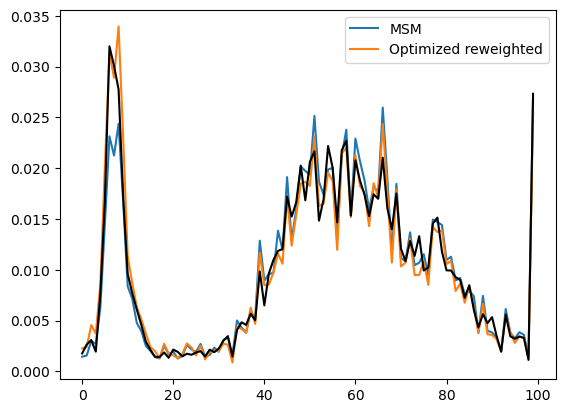

In [16]:
plt.plot(msm_equil, label='MSM')

plt.plot(reweighted_equil, label='Optimized reweighted')

plt.plot(ref_equil, color='k')

plt.legend()

In [17]:
msm_entropy = entropy(msm_equil, ref_equil)
reweighted_entropy = entropy(reweighted_equil, ref_equil)

In [18]:
print("Relative entropies to reference (lower is better)")
print(f"MSM estimate: \t{msm_entropy:.2e}")
print(f"Reweighted estimate: \t{reweighted_entropy:.2e}")

Relative entropies to reference (lower is better)
MSM estimate: 	1.09e-02
Reweighted estimate: 	9.92e-03
